In [1]:
!pip install gymnasium torch opencv-python gymnasium[atari] gymnasium[accept-rom-license] matplotlib

In [2]:
import gymnasium as gym
import gymnasium.spaces
import torch as T
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import deque

In [3]:
class RepeatActionMaxFrame(gym.Wrapper):
    '''
        Atari Preprocessing
        
        - Used to solve the issue where the atari library only renders some images on even frames and others on odd frames.
        - Handles the ability to repeat the last action a number of times to lighten the load of processing every frame. 
    '''
    def __init__(self, environment, repeat = 4, clip_reward = False, no_ops = 0, fire_first = False):
        super(RepeatActionMaxFrame, self).__init__(environment)
        self.environment = environment
        self.shape = environment.observation_space.low.shape
        self.repeat = repeat
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first
        
        #init the frame buffer to hold our 2 frames (overcome flickering)
        self.frame_buffer = np.zeros_like((2, self.shape))
        
    def step(self, action):
        total_reward = 0.
        terminated = False
        truncated = False
        
        for i in range(self.repeat):
            observation, reward, terminated, truncated, info = self.environment.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            total_reward += reward
        
            index = i % 2
            self.frame_buffer[index] = observation
            if terminated or truncated:
                break
            
        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, total_reward, terminated, truncated, info    
    
    def reset(self, **kwargs):
        observation, properties = self.environment.reset()
        no_ops = np.random.randint(self.no_ops) + 1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, terminated, truncated, _ = self.environment.step(0)
            if done:
                self.environment.reset()
        
        if self.fire_first:
            assert self.environment.unwrapped.get_action_meanings()[1] == 'FIRE'
            observation, _, _, _, _ = self.environment.step(0)
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.frame_buffer[0] = observation 
        return observation, properties
        
                 

In [4]:
class PreprocessFrame(gym.ObservationWrapper):
    '''
        Resize the frame
    '''
    def __init__(self, environment, new_shape):
        super(PreprocessFrame, self).__init__(environment)
        self.environment = environment
        self.shape = (new_shape[2], new_shape[0], new_shape[1]) 
        
        self.observation_space = gym.spaces.Box(low = 0.0, high = 1.0, shape = self.shape, dtype = np.float32)
        
    def observation(self, raw_observation):
        im = cv2.cvtColor(raw_observation, cv2.COLOR_RGB2GRAY)
        im = cv2.resize(im, self.shape[1:], interpolation = cv2.INTER_AREA)
        im = np.array(im, dtype = np.uint8).reshape(self.shape)
        
        im = im / 255.0
        
        return im


In [5]:
class StackFrames(gym.ObservationWrapper):
    '''
    
    '''
    def __init__(self, environment, stack_size):
        super(StackFrames, self).__init__(environment)
        
        self.environment = environment
        self.observation_space = gym.spaces.Box(environment.observation_space.low.repeat(stack_size, axis = 1), 
                                                environment.observation_space.high.repeat(stack_size, axis = 1), 
                                                dtype = np.float32)
        
        self.frame_stack = deque(maxlen = stack_size)
        
    def reset(self):
        self.frame_stack.clear()
        
        observation, properties = self.environment.reset()
        
        for _ in range(self.frame_stack.maxlen):
            self.frame_stack.append(observation)

        return np.array(self.frame_stack).reshape(self.observation_space.low.shape), properties
    
    def observation(self, observation):
        self.frame_stack.append(observation)
        return np.array(self.frame_stack).reshape(self.observation_space.low.shape)
            

In [6]:
def make_environment(environment_name, shape = (84, 84, 1), repeat = 4, clip_reward = False, no_ops = 0, fire_first = False):
    environment = gym.make(environment_name)
    environment = RepeatActionMaxFrame(environment, repeat, clip_reward, no_ops, fire_first)
    environment = PreprocessFrame(environment, shape)
    environment = StackFrames(environment, repeat)
    
    return environment

In [7]:
def plot_learning_curve(x, scores, epsilons, filename):
    figure = plt.figure()
    ax = figure.add_subplot(111, label = "1")
    ax2 = figure.add_subplot(111, label = "2", frame_on = False)
    
    ax.plot(x, epsilons, color = "C0")
    ax.set_xlabel("Training Steps", color = "C0")
    ax.set_ylabel("Epsilon", color = "C0")
    ax.tick_params(axis = "x", colors = "C0")
    ax.tick_params(axis = "y", colors = "C0")
    
    N = len(scores)
    running_average = np.empty(N)
    for t in range(N):
        running_average[t] = np.mean(scores[max(0, t - 100):(t + 1)])
        
    ax2.scatter(x, running_average, color = "C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color = "C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis = "y", colors = "C1")
    
    plt.savefig(filename)

In [8]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, num_actions):
        self.mem_size = max_size
        self.mem_counter = 0
        
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype = np.float32)
        
        self.action_memory = np.zeros(self.mem_size, dtype = np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float32)
        
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.uint8)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.mem_counter += 1
        
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace = False)
        
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]
        
        return states, actions, rewards, states_, dones
        
        

In [9]:
class DuelingDeepQNetwork(nn.Module):
    def __init__(self, learning_rate, num_classes, file_name, input_dimensions, checkpoint_directory):
        super(DuelingDeepQNetwork, self).__init__()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.checkpoint_directory = checkpoint_directory
        self.checkpoint_file = os.path.join(self.checkpoint_directory, file_name)
        
        self.conv_layer_1 = nn.Conv2d(input_dimensions[0], 32, 8, stride=4, device = self.device)
        self.conv_layer_2 = nn.Conv2d(32, 64, 4, stride=2, device = self.device)
        self.conv_layer_3 = nn.Conv2d(64, 32, 3, stride=1, device = self.device)
        
        fc_input_size = self.find_input_size(input_dimensions)
        
        self.fully_connected_1 = nn.Linear(fc_input_size, 512, device = self.device)

        self.fully_connected_value = nn.Linear(512, 1, device = self.device)
        self.fully_connected_advantage = nn.Linear(512, num_classes, device = self.device)
        
        self.optimizer = optim.RMSprop(self.parameters(), lr = learning_rate)
        self.loss = nn.MSELoss()
        
        self.to(self.device)
        
    def forward(self, data):
        
        con_layer1_output = F.relu(self.conv_layer_1(data))
        con_layer2_output = F.relu(self.conv_layer_2(con_layer1_output))
        con_layer3_output = F.relu(self.conv_layer_3(con_layer2_output))
        
        conv_state = con_layer3_output.view(con_layer3_output.size()[0], -1) # flatten the convolutions
        
        fc_layer1_output = F.relu(self.fully_connected_1(conv_state))
        
        fc_value_output = self.fully_connected_value(fc_layer1_output)
        
        fc_advantage_output = self.fully_connected_advantage(fc_layer1_output)
      
        return fc_value_output, fc_advantage_output
    
    def learn(self, data, labels):
        self.optimizer.zero_grad()
        data = T.tensor(data).to(self.device)
        labels = T.tensor(labels).to(self.device)
        
        predictions = self.forward(data)
        
        cost = self.loss(predictions, labels)
        
        cost.backward()
        self.optimizer.step()
    
    def find_input_size(self, input_dimensions):
        input_zeros = T.zeros(1, *input_dimensions).to(self.device)
        dims = self.conv_layer_1(input_zeros)
        dims = self.conv_layer_2(dims)
        dims = self.conv_layer_3(dims)
        #print(int(np.prod(dims.size())))
        return int(np.prod(dims.size()))
    
    def save_checkpoint(self):
        print('... Saving Checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print('... Loading Checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))
        

In [10]:
class DuelingDeepQAgent():
    def __init__(self, learning_rate = 0.0001, gamma = 0.99, epsilon = 1.0, epsilon_min = 0.01, epsilon_decrement = 5e-7, \
                 num_actions = 2, memory_size = 2, batch_size = 32, num_states = (4, 1), algorithm = None, replace = 1000, input_dimensions = 8, \
                 checkpoint_directory = 'checkpoints/dqn', environment_name = None):
        self.learning_rate = learning_rate # alpha
        self.gamma = gamma # discount_factor
        self.epsilon = epsilon # explore exploit rate
        self.num_actions = num_actions
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = epsilon_decrement
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.algorithm = algorithm
        self.replace_target_count = replace
        self.input_dimensions = input_dimensions
        self.checkpoint_directory = checkpoint_directory
        self.environment_name = environment_name
        self.action_space = [i for i in range(self.num_actions)]
        self.learn_step_counter = 0
        
        self.memory = ReplayBuffer(memory_size, input_dimensions, num_actions)
        
        self.q_eval = DuelingDeepQNetwork(self.learning_rate, self.num_actions, input_dimensions = self.input_dimensions, file_name = self.environment_name + '_' + self.algorithm + '_q_eval', \
                                   checkpoint_directory = self.checkpoint_directory)
        
        self.q_next = DuelingDeepQNetwork(self.learning_rate, self.num_actions, input_dimensions = self.input_dimensions, file_name = self.environment_name + '_' + self.algorithm + '_q_next', \
                                   checkpoint_directory = self.checkpoint_directory)
        
        
    def choose_action(self, current_state):
        random_number = np.random.random()
        if random_number < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            _, advantage = self.q_eval.forward(T.tensor([current_state], dtype=T.float).to(self.q_eval.device))
            return T.argmax(advantage).item()
            
    def store_transition(self, state, action, reward, state_, terminated):
        self.memory.store_transition(state, action, reward, state_, terminated)
        
    def sample_memory(self):
        state, action, reward, state_, terminated = self.memory.sample_buffer(self.batch_size)
        
        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        terminateds = T.tensor(terminated).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(state_).to(self.q_eval.device)
        
        return states, actions, rewards, states_, terminateds
    
    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_count == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())
            
    def decrement_epsilon(self):
        '''
        Decrement epsilon
        '''
        self.epsilon = self.epsilon - self.epsilon_decrement if self.epsilon > self.epsilon_min else self.epsilon_min
        
    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()
        
    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()
    
    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return
        
        self.q_eval.optimizer.zero_grad()
        
        self.replace_target_network()
        
        states, actions, rewards, states_, dones = self.sample_memory()
        
        indices = np.arange(self.batch_size)
        
        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)
        
        q_pred = T.add(V_s, (A_s - A_s.mean(dim = 1, keepdim = True)))[indices, actions]
        q_next = T.add(V_s_, (A_s_ - A_s_.mean(dim = 1, keepdim = True))).max(dim = 1)[0]
        
        q_next[dones == 1] = 0.0
        q_target = rewards + self.gamma * q_next
        
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1
        
        self.decrement_epsilon()
    

In [11]:
env_name = 'PongNoFrameskip-v4'
environment = make_environment(env_name)
best_score = -np.inf
load_checkpoint = False
number_games = 300

agent = DuelingDeepQAgent(gamma = 0.99, epsilon = 1.0, learning_rate = 0.0001, input_dimensions = (environment.observation_space.shape), num_actions = environment.action_space.n, \
                   memory_size = 80000, epsilon_min = 0.1, batch_size = 32, replace = 1000, epsilon_decrement = 1e-5, checkpoint_directory = 'models/', algorithm = 'DuelingDQNAgent', \
                   environment_name = env_name)

if load_checkpoint:
    agent.load_models()
    
filename = agent.algorithm + '_' + agent.environment_name + '_lr' + str(agent.learning_rate) + '_' + \
    str(number_games) + '_games'
figure_file = 'plots/' + filename + '.png'

num_steps = 0
scores, epsilon_history, steps_array = [], [], []

for game_counter in range(number_games):
    terminated, truncated = False, False
    score = 0
    observation, properties = environment.reset()
    
    while not terminated and not truncated:
        action = agent.choose_action(observation)
        observation_, reward, terminated, truncated, info = environment.step(action)
        score += reward
        
        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, int(terminated))
            agent.learn()
        observation = observation_
        num_steps += 1
        
    scores.append(score)
    steps_array.append(num_steps)
    
    average_score = np.mean(scores[-100:])
    if game_counter % 10 == 0:
        print(f"Episode: {game_counter} Score: {score} Average Score: {average_score:.1} Best Score: {best_score:.1} Epsilon: {agent.epsilon:.2} Steps: {num_steps}")
    
    if average_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = average_score
    
    epsilon_history.append(agent.epsilon)
    

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/tmp/ipykernel_194/2405011126.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  _, advantage = self.q_eval.forward(T.tensor([current_state], dtype=T.float).to(self.q_eval.device))


Episode: 0 Score: -20.0 Average Score: -2e+01 Best Score: -inf Epsilon: 0.99 Steps: 925
... Saving Checkpoint ...
... Saving Checkpoint ...
Episode: 10 Score: -21.0 Average Score: -2e+01 Best Score: -2e+01 Epsilon: 0.9 Steps: 10327
Episode: 20 Score: -17.0 Average Score: -2e+01 Best Score: -2e+01 Epsilon: 0.79 Steps: 20637
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
Episode: 30 Score: -21.0 Average Score: -2e+01 Best Score: -2e+01 Epsilon: 0.69 Steps: 31327
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
Episode: 40 Score: -18.0 Average Score: -2e+01 Best Score: -2e+01 Epsilon: 0.55 Steps: 44588
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint ...
... Saving Checkpoint

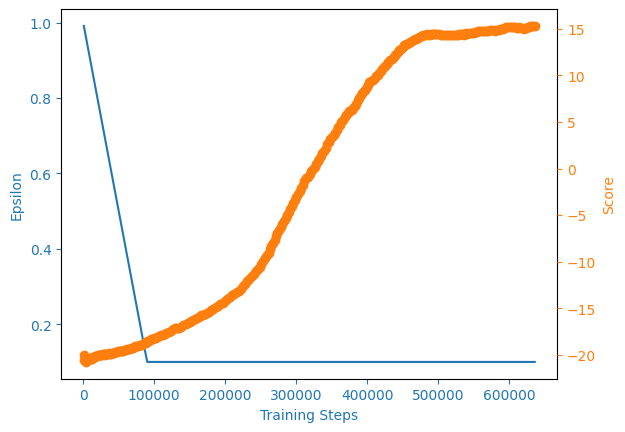

In [12]:
plot_learning_curve(steps_array, scores, epsilon_history, figure_file)  